## Weather Forecasting using ML and GA (Current Data)

### Data Extraction

In [11]:
from meteostat import Point, Daily
from datetime import datetime
import pandas as pd

city = Point(12.971599, 77.594566) 
start_date = datetime(2024, 1, 31)  
end_date = datetime(2024, 11, 30) 

data = Daily(city, start=start_date, end=end_date)
data = data.fetch()

data = pd.DataFrame(data)
print(data)

            tavg  tmin  tmax  prcp  snow   wdir  wspd  wpgt    pres  tsun
time                                                                     
2024-01-31  23.0  16.6  30.6   0.0   NaN  141.0   8.5   NaN  1015.8   NaN
2024-02-01  23.6  18.0  30.0   0.0   NaN  181.0   7.3   NaN  1015.9   NaN
2024-02-02  24.0  17.9  30.6   0.0   NaN  139.0   7.8   NaN  1015.4   NaN
2024-02-03  24.2  18.9  30.3   0.0   NaN  110.0  10.1   NaN  1016.0   NaN
2024-02-04  23.3  16.9  30.0   0.0   NaN   93.0  10.9   NaN  1017.8   NaN
...          ...   ...   ...   ...   ...    ...   ...   ...     ...   ...
2024-11-26  21.2  17.8  25.5   2.1   NaN   42.0  15.9   NaN  1012.5   NaN
2024-11-27  21.2  18.1  24.4   0.5   NaN   37.0  16.4   NaN  1011.3   NaN
2024-11-28  21.8  17.3  26.5   0.0   NaN   25.0  15.0   NaN  1011.0   NaN
2024-11-29  21.2  18.4  25.0   0.0   NaN   20.0  16.6   NaN  1010.8   NaN
2024-11-30  21.1  19.0  22.9   0.7   NaN  354.0  19.3   NaN  1009.2   NaN

[305 rows x 10 columns]


### Data Preprocessing and Visualization

In [12]:
data=data.drop(columns=['wpgt','tsun','snow'])
data=data.dropna()

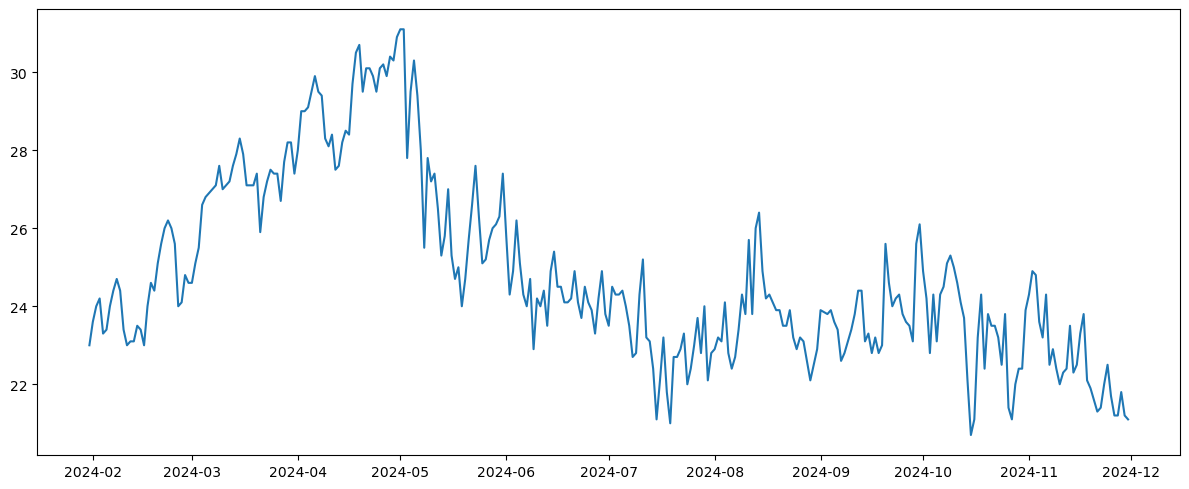

In [13]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 5))
plt.plot(data['tavg'])
plt.tight_layout()
plt.show()

In [14]:
from sklearn.preprocessing import StandardScaler
X=data.drop(columns='tavg')
Y=data['tavg']
X=StandardScaler().fit_transform(X)

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

### ML without GA

In [16]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)
y_pred_baseline = model.predict(X_test)

baseline_mse = mean_squared_error(y_test, y_pred_baseline)
baseline_r2 = r2_score(y_test, y_pred_baseline)
print(f"Baseline MSE: {baseline_mse}, R²: {baseline_r2}")


Baseline MSE: 0.4457043770491821, R²: 0.9259028560488811


### ML with GA

In [17]:
from sklearn.model_selection import cross_val_score

def objective_function(params):
    n_estimators = int(params[0])
    max_depth = int(params[1])
    min_samples_split = int(params[2])

    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        random_state=42,
    )
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring='neg_mean_squared_error')
    return -scores.mean()

 The best solution found:                                                                           
 [59.  7.  2.]

 Objective function:
 0.551256276419261


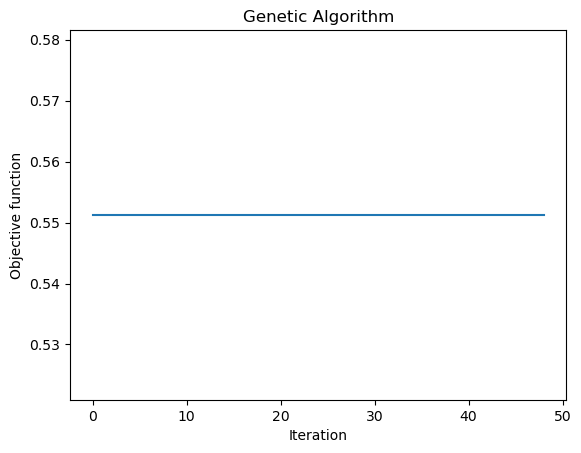

Optimized MSE: 0.44073417580142604, R²: 0.926729138527324


In [18]:
import numpy as np
from geneticalgorithm import geneticalgorithm as ga
param_bounds = np.array([
    [50,60],  # n_estimators
    [5,8],    # max_depth
    [2,5]     # min_samples_split
])

# Run GA
ga_model = ga(function=objective_function, dimension=3, variable_type='int', variable_boundaries=param_bounds)
ga_model.run()

best_params = ga_model.output_dict['variable']
optimized_model = RandomForestRegressor(
    n_estimators=int(best_params[0]),
    max_depth=int(best_params[1]),
    min_samples_split=int(best_params[2]),
    random_state=42
)
optimized_model.fit(X_train, y_train)
y_pred_optimized = optimized_model.predict(X_test)

optimized_mse = mean_squared_error(y_test, y_pred_optimized)
optimized_r2 = r2_score(y_test, y_pred_optimized)
print(f"Optimized MSE: {optimized_mse}, R²: {optimized_r2}")


### Comparison

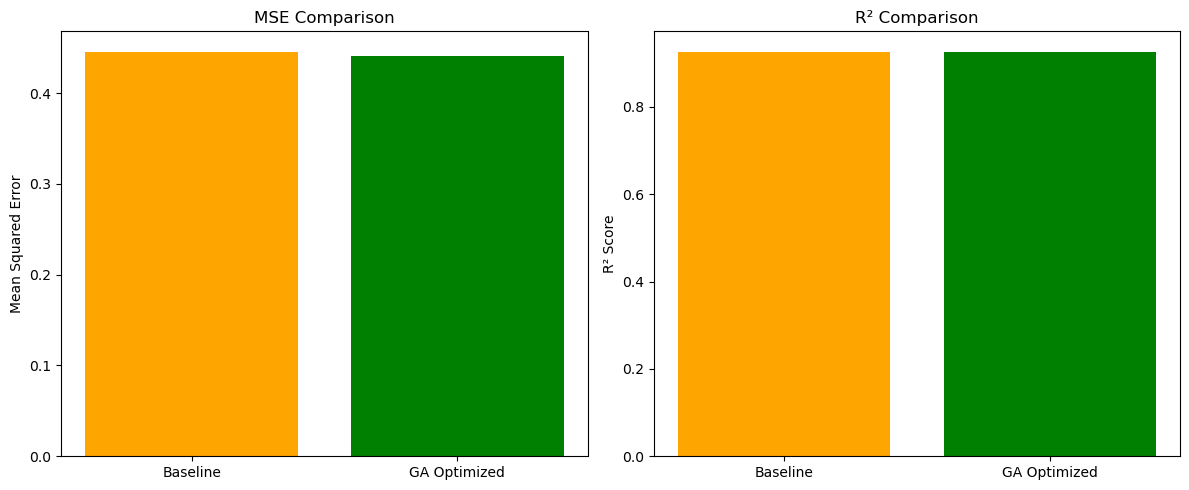

In [19]:

labels = ['Baseline', 'GA Optimized']
mse_values = [baseline_mse, optimized_mse]
r2_values = [baseline_r2, optimized_r2]

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.bar(labels, mse_values, color=['orange', 'green'])
plt.title('MSE Comparison')
plt.ylabel('Mean Squared Error')

plt.subplot(1, 2, 2)
plt.bar(labels, r2_values, color=['orange', 'green'])
plt.title('R² Comparison')
plt.ylabel('R² Score')

plt.tight_layout()
plt.show()


From the above comparison we can see that there isn't much difference between with and without GA for this data because randomforest is an ensemble technique 

## END